In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import anaclass
import mcmc_aux

In [7]:
data = mcmc_aux.prep_run("../../data/3000_12_8/")

data.select_chunks()

data.pick_start()

dividing your sample into 30 sets
chose a random sample to use as the real data!


In [8]:
data.theta_0

array([2.15789474, 0.05263158, 0.63157895])

In [9]:
def MODEL(theta):
    
    alpha, delta, sigma = theta

    lgMs_2D = galhalo.SHMR(data.lgMh, alpha, delta, sigma) # will be a 3D array if sigma is non zero
    
    counts = np.apply_along_axis(anaclass.cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    mass_ind = anaclass.find_nearest([6.5, 7, 7.5])

    model = [] # counts at the mass indicies
    for i in mass_ind:
        model.append(quant[2, i])
        model.append(quant[1, i])
        model.append(quant[0, i])

    return np.array(model)

In [10]:
def lnlike(theta):
    model = MODEL(theta)
    X = model - data.D
    X_vec = np.expand_dims(X, axis=1)
    chisquare = X_vec.transpose().dot(data.inv_covar).dot(X_vec)
    return -1/2*np.sum(chisquare)


def lnprior(theta):
    alpha, delta, sigma = theta
    if 0.5 < alpha < 3.5 and -0.5 < delta < 3.5 and 0 < sigma < 4:
        return 0.0
    return -np.inf


def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [14]:
def MCMC_RUN(theta_0, nwalkers=100, niter=100, ndim=3, burn=20, ncores=7):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        p1, _, _ = sampler.run_mcmc(p0, burn)
        sampler.reset()
        sampler.run_mcmc(p1, niter)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))

    np.save("../../data/3000_12_8/mcmc_"+str(nwalkers)+"_"+str(niter)+".npy", sampler.get_chain())

    tau = sampler.get_autocorr_time()
    print('$\\alpha$ took', tau[0], 'steps')
    print('$\\delta$ took', tau[1], 'steps')
    print('$\\sigma$ took', tau[2], 'steps')

In [15]:
MCMC_RUN(theta_0=data.theta_0, ncores=7)

Multiprocessing took 11.0 seconds


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.6389258  10.91581008 10.60619494]

In [23]:
run = mcmc_aux.inspect_run("../../data/3000_12_8/", "mcmc_100_100.npy")

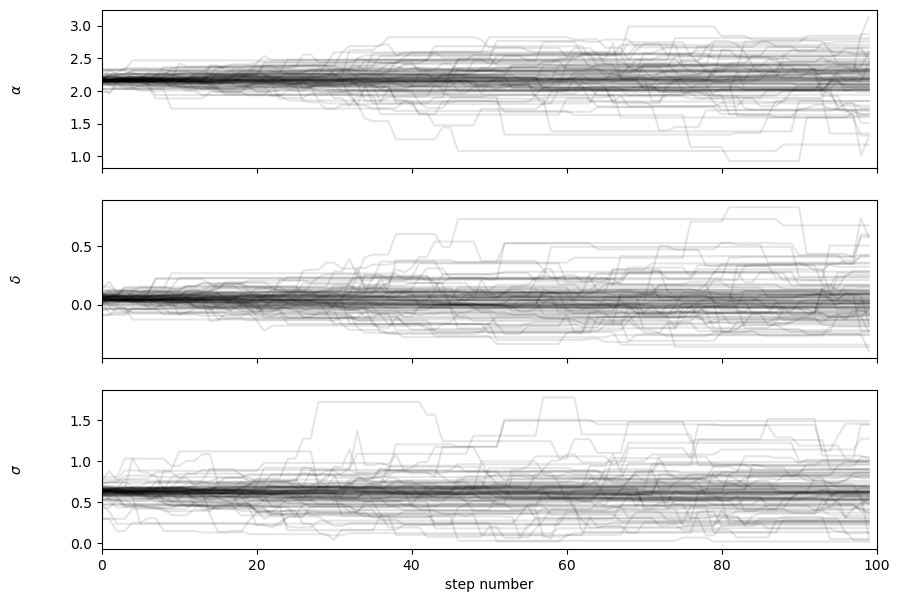

In [24]:
run.make_chain_plot()

In [26]:
run.make_corner_plot(stack=True)

AssertionError: The input sample array must be 1- or 2-D.

In [ ]:
samples = sampler.get_chain()

In [ ]:
halo_masses = np.log10(np.logspace(6, 13, 100)) # just for the model

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(halo_masses, galhalo.lgMs_B13(halo_masses), color="red", label="Behroozi et al. 2013", ls="--")
plt.plot(halo_masses, galhalo.lgMs_RP17(halo_masses), color="navy", label="Rodriguez-Puebla et al. 2017", ls="-.")
plt.plot(halo_masses, SHMR(halo_masses, alpha=1.85, delta=0.2, sigma=0.2), color="black", label="Fiducial: $\\alpha=1.85, \\delta=0.2, \sigma=0.2$")

for i in samples[999]:
    alpha, delta, sigma = i
    plt.plot(halo_masses, SHMR(halo_masses,alpha, delta, sigma), color="grey", alpha=0.01)

plt.ylim(0,11)
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend(fontsize=12)
plt.xlim(6,11.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

for i in samples[999]:
    alpha, delta, sigma = i
    lgMs_2D = SHMR(lgMh_data, alpha, delta, sigma)
    counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter
    plt.plot(np.linspace(4,11,45), quant[1], alpha=0.1, color="grey")


lgMs_2D = SHMR(lgMh_data, 1.85, 0.2, 0.3)
counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter
plt.plot(np.linspace(4,11,45), quant[1], color="black", label="Fiducial: $\\alpha=1.85, \\delta=0.2, \sigma=0.2$")

plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend(fontsize=12)
plt.xlim(4,11)
plt.show()

In [ ]:
# import pygtc
# truths=[1.85, 0.2, 0.3]
# labels = ['$\\alpha$','$\\delta$','$\\sigma$']

# fig = pygtc.plotGTC(samples[999], truths = truths, paramNames=labels, figureSize='MNRAS_page')